In [121]:
import sqlite3
import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import MathsUtilities as MUte
import matplotlib.patheffects as path_effects
%matplotlib inline

### Link to APSIM output Data

In [3]:
con = sqlite3.connect(r'C:\GitHubRepos\ApsimX\Prototypes\Potato\Potato.db')

### Read the Simulations table that has SimulationID matched to Simulation Name

In [4]:
Simulations = pd.read_sql("Select * from _Simulations",
                                con)
Simulations.set_index('ID',inplace=True)

### Read in the Factor table that links factor names and levels to simulation IDs

In [5]:
Factors = pd.read_sql("Select * from _Factors",
                        con)
Factors.set_index('SimulationID',inplace=True)

### Read in the Report generated on the Sowing Event

In [6]:
LocList = pd.read_excel(r'C:\Users\cflhxb\Dropbox\APSIMPotato\List of locations.xlsx')
LocList.set_index('metfile',inplace=True)

In [7]:
import re
def extractLocation(lcn):
    lcn = lcn.replace('MET files\\','')
    lcn = re.sub('\d','',lcn)
    lcn = lcn.replace('.met','')
    return lcn
def extractfileName(fn):
    fn = fn.replace('MET files\\','')
    fn = fn.replace('.met','')
    return fn

In [8]:
Obs = pd.read_sql("Select * from Observed",
                        con)
Obs.set_index('SimulationID',inplace=True)

In [9]:
InitialReport = pd.read_sql("Select * from InitialReport",
                        con)
InitialReport.loc[:,'SimulationName'] = [Simulations.loc[InitialReport.loc[x,'SimulationID'],'Name'] for x in InitialReport.index]
InitialReport.drop(['CheckpointID','Zone','Nitrogen','01','1','Field_','_','Water','Radiation','PlantDensity'],axis=1,inplace=True)
InitialReport.set_index('SimulationID',inplace=True)
InitialReport.loc[:,'Location'] = [extractLocation(x) for x in InitialReport.loc[:,'Weather.FileName']]
InitialReport.loc[:,'FileName'] = [extractfileName(InitialReport.loc[x,'Weather.FileName']) for x in InitialReport.index]
InitialReport.loc[:,'Country'] = [LocList.loc[x,'country'] for x in InitialReport.loc[:,'FileName']]
InitialReport.loc[:,'Loc'] = [LocList.loc[x,'loc'] for x in InitialReport.loc[:,'FileName']]
InitialReport.loc[:,'Country Loc'] = [InitialReport.loc[x,'Country'] + ' ' + InitialReport.loc[x,'Loc'] for x in InitialReport.index] 

In [10]:
DailyReport = pd.read_sql("Select * from DailyReport",
                        con)
DailyReport.loc[:,'SimulationName'] = [Simulations.loc[DailyReport.loc[x,'SimulationID'],'Name'] for x in DailyReport.index]
DailyReport.drop(['CheckpointID','Zone','Nitrogen','01','1','Field_','_','Water','Radiation','PlantDensity'],axis=1,inplace=True)
DailyReport.set_index('SimulationID',inplace=True)

In [11]:
DailyPreObs = pd.read_sql("Select * from TimeSeriesData",
                        con)
DailyPreObs.loc[:,'SimulationName'] = [Simulations.loc[DailyPreObs.loc[x,'SimulationID'],'Name'] for x in DailyPreObs.index]
DailyPreObs.set_index('SimulationID',inplace=True)
DailyPreObs.drop_duplicates(inplace=True)

In [12]:
HarvestReport = pd.read_sql("Select * from HarvestReport",
                        con)
HarvestReport.loc[:,'SimulationName'] = [Simulations.loc[HarvestReport.loc[x,'SimulationID'],'Name'] for x in HarvestReport.index]
HarvestReport.drop(['CheckpointID','Zone','Nitrogen','01','1','Field_','_','Water','Radiation','PlantDensity'],axis=1,inplace=True)
HarvestReport.loc[:,'PlantPopn'] = 1/((HarvestReport.loc[:,'RowWidth']/1000)* (HarvestReport.loc[:,'InterRowPlantSpace']/1000))
HarvestReport.loc[:,'StemPopn'] = HarvestReport.loc[:,'StemPerTuber'] *  HarvestReport.loc[:,'PlantPopn']
HarvestReport.loc[:,'Location'] = [extractLocation(x) for x in HarvestReport.loc[:,'Weather.FileName']]
HarvestReport.set_index('SimulationID',inplace=True)
HarvestReport.loc[:,'FileName'] = [extractfileName(HarvestReport.loc[x,'Weather.FileName']) for x in HarvestReport.index]
HarvestReport.loc[:,'Country'] = [LocList.loc[x,'country'] for x in HarvestReport.loc[:,'FileName']]
HarvestReport.loc[:,'Loc'] = [LocList.loc[x,'loc'] for x in HarvestReport.loc[:,'FileName']]
HarvestReport.loc[:,'Country Loc'] = [HarvestReport.loc[x,'Country'] + ' ' + HarvestReport.loc[x,'Loc'] for x in HarvestReport.index] 

In [13]:
HarvestPreObs = pd.read_sql("Select * from FinalYieldData",
                        con)
HarvestPreObs.loc[:,'SimulationName'] = [Simulations.loc[HarvestPreObs.loc[x,'SimulationID'],'Name'] for x in HarvestPreObs.index]
HarvestPreObs.set_index('SimulationID',inplace=True)
HarvestPreObs.drop_duplicates(inplace=True)

### List of simulation names that are in observations data set but are not triggering a sowing event

In [14]:
NotPlanted = []
for x in DailyPreObs.index.get_level_values(0).drop_duplicates():
    if x not in InitialReport.index:
        NotPlanted.append(Simulations.loc[x,'Name'])
NotPlanted

['SFF_03_04SituationHoweyNitrogenBase',
 'SFF_03_04SituationHoweyNitrogenGrower',
 'SFF_03_04SituationHoweyNitrogenPC']

## List of Simulation names that are being planted but are not triggering a harvest event

In [15]:
NotHarvested = []
for x in InitialReport.index:
    if x not in HarvestReport.index:
        NotHarvested.append(Simulations.loc[x,'Name'])
NotHarvested

[]

In [17]:
Experiments = HarvestReport.Experiment.drop_duplicates().values
Experiments

array(['ABlock', 'Baxters', 'FUE', 'FSP', 'FUE_NI', 'LincolnRS2018',
       'PYM98', 'PYM99', 'Lynetts', 'Parilla', 'rainshelter',
       'Penola_0607', 'Glenroy_0607', None, 'SCRI_84', 'SCRI_86',
       'AUCB7001', 'CHBE9801', 'CHBE9901', 'CHGR98', 'CHGR980', 'CHIE98',
       'CHIE980', 'CHIT98', 'CHIT980', 'CHSE98', 'CPLI9201',
       'DIJY8401Tylva_84', 'DIJY8401Tylva_85', 'DIJY8401Tylva_86',
       'DIJY9001Kap_90', 'DIJY9001Kap_92', 'DIJY9001Kap_91',
       'DIJY9001Kap_93', 'DITY8101_81', 'DITY8101_82', 'DITY8101_83',
       'IAHM9801', 'IAWM9901', 'INBA9101', 'IPSG8501', 'OSBO8801NASA_PIX',
       'PRBE9701', 'PRKO9701', 'PRPA9701', 'PRPT9801', 'PRPT9802',
       'PRTO9301', 'PULU0801_2008', 'PULU0801_2010', 'SCDU8401_1984',
       'SCDU8401_1985', 'SFUF1001_2011', 'SFUF1001_2012', 'UFHA1001_F1',
       'UFHA1001_F2', 'UFHA1001_F3', 'UFSF01', 'UFSF010', 'SRF',
       'SFF_02_03SituationHewson', 'SFF_02_03SituationHowey',
       'SFF_02_03SituationNewton', 'SFF_02_03SituationPye'

In [18]:
Folders = ['New Zealand', 'Australia', 'SubStor','Scotland']

In [19]:
Locations = HarvestReport.loc[:,'Loc'].drop_duplicates().values
Locations.sort()
Countries = HarvestReport.loc[:,'Country'].drop_duplicates().values
Countries.sort()
CountryLocs = HarvestReport.loc[:,'Country Loc'].drop_duplicates().values
CountryLocs.sort()

In [19]:
Locations

array(['Balcarce', 'Barrington', 'Belen', 'Benton', 'Branxholm',
       'Canberra', 'Carlow', 'Chertsy', 'Chinoli', 'Coonawarra', 'Cressy',
       'Deloraine', 'Dundee', 'Epping', 'Forthside', 'Giessen',
       'Gothenburg', 'Gunnsplains', 'Hastings', 'Hermiston', 'Huhhot',
       'Jining', 'Jyndevad', 'Kalangadoo', 'Kalengyere', 'Koari',
       'La Molina', 'Lameroo', 'Latrobe', 'Lincoln', 'Ludhiana',
       'Modipuran', 'Patacamaya', 'Pukehohe', 'Rapolano', 'San Gabriel',
       'San Ramon', 'Sassafras', 'Sheffield', 'Suwanee', 'Temuka',
       'Tervuren', 'Toralapa', 'Tylstrup', 'Ulverstone', 'Westbury',
       'Wynyard', 'Zhalan'], dtype=object)

In [20]:
Countries

array(['Argentina', 'Australia', 'Belgium', 'Bolivia', 'China', 'Denmark',
       'Ecuador', 'Germany', 'India', 'Ireland', 'Italy', 'New Zealand',
       'Peru', 'Scotland', 'Sweden', 'Uganda', 'United States'],
      dtype=object)

In [23]:
CountryLocs

array(['Argentina Balcarce', 'Australia Barrington',
       'Australia Branxholm', 'Australia Canberra',
       'Australia Coonawarra', 'Australia Cressy', 'Australia Deloraine',
       'Australia Epping', 'Australia Forthside', 'Australia Gunnsplains',
       'Australia Kalangadoo', 'Australia Lameroo', 'Australia Latrobe',
       'Australia Sassafras', 'Australia Sheffield',
       'Australia Ulverstone', 'Australia Westbury', 'Australia Wynyard',
       'Belgium Tervuren', 'Bolivia Belen', 'Bolivia Chinoli',
       'Bolivia Koari', 'Bolivia Patacamaya', 'Bolivia Toralapa',
       'China Huhhot', 'China Jining', 'China Zhalan', 'Denmark Jyndevad',
       'Denmark Tylstrup', 'Ecuador San Gabriel', 'Germany Giessen',
       'India Ludhiana', 'India Modipuran', 'Ireland Carlow',
       'Italy Rapolano', 'New Zealand Chertsy', 'New Zealand Hastings',
       'New Zealand Lincoln', 'New Zealand Pukehohe',
       'New Zealand Temuka', 'Peru La Molina', 'Peru San Ramon',
       'Scotland Dun

In [167]:
AllColors = ['black',
 'grey',
 'lightgrey',
 'maroon',
 'indianred',
 'red',
 'darksalmon',
 'lightsalmon',
 'saddlebrown',
 'peru',
 'darkorange',
 'navajowhite',
 'goldenrod',
 'gold',
 'darkkhaki',
 'olive',
 'yellow',
 'yellowgreen',
 'darkolivegreen',
 'darkseagreen',
 'limegreen',
 'lime',
 'springgreen',
 'mediumspringgreen',
 'lightseagreen',
 'darkslategray',
 'darkcyan',
 'dodgerblue',
 'slategray',
 'lightsteelblue',
 'royalblue',
 'navy',
 'darkslateblue',
 'mediumpurple',
 'rebeccapurple',
 'darkorchid',
 'violet',
 'purple',
 'crimson',
 'pink']

In [25]:
Cultivars = HarvestReport.Cultivar.drop_duplicates().values
Cultivars.sort()
Cultivars

array(['39707716', 'Achirana', 'Alpha', 'Amarilis', 'Asante', 'Atlantic',
       'Bintje', 'Coliban', 'Desiree', 'Dianella', 'Fianna', 'Gabriela',
       'Horizon', 'Ib0005', 'IlamHardy', 'JerseyBenny', 'Jinguan',
       'Kaptah', 'Karaka', 'Kexin', 'Kufri Bahar', 'Luky', 'Maria',
       'Maris Piper', 'Moonlight', 'Nadine', 'Neishu', 'Nooksac', 'Posmo',
       'Red Lasoda', 'RedRascal', 'Rua', 'RussetBurbank', 'RussetRanger',
       'Sava', 'Sebago', 'Spunta', 'Tylva', 'Waycha', 'Zibaihua'],
      dtype=object)

In [26]:
CultivarAcronums = ['39','Ac','Al','Am','As','At','Bi','Co','De','Di','Fi','Ga','Ho','Ib','Ih','Jb',
'Ji','Ka','Kr','Ke','Kb','Lu','Ma','Mp','Ml','Na','Ne','No','Po','Rl','Re','Ru',
 'Rb','Rr','Sa','Se','Sp','Ty','Wa','Zi']

In [169]:
CountryProps

Color
Argentina               black
Australia           lightgrey
Belgium             indianred
Bolivia            darksalmon
China             saddlebrown
Denmark            darkorange
Ecuador             goldenrod
Germany             darkkhaki
India                  yellow
Ireland        darkolivegreen
Italy               limegreen
New Zealand       springgreen
Peru            lightseagreen
Scotland             darkcyan
Sweden              slategray
Uganda              royalblue
United States   darkslateblue

In [168]:
CountryProps = pd.DataFrame(index = Countries,columns=['Color'])
pos = 0
for x in CountryProps.index:
    CountryProps.loc[x,'Color'] = AllColors[pos]
    pos += 2
CultivarProps = pd.DataFrame(index = Cultivars, data=CultivarAcronums, columns = ['CultAcro'])
pos=0
for x in CultivarProps.index:
    CultivarProps.loc[x,'Color'] = AllColors[pos]
    pos+=1

ColProps = pd.DataFrame(index=HarvestReport.index)
ColProps.loc[:,'Cultivar'] = CultivarProps.loc[[HarvestReport.loc[x,'Cultivar'] for x in ColProps.index],'Color'].values
ColProps.loc[:,'Country'] = CountryProps.loc[[HarvestReport.loc[x,'Country'] for x in ColProps.index],'Color'].values
ColProps

Cultivar      Country
SimulationID                             
1                 dodgerblue  springgreen
5                      olive  springgreen
7                  goldenrod  springgreen
4                  darkkhaki  springgreen
2                  royalblue  springgreen
6             darkolivegreen  springgreen
3              darkslateblue  springgreen
12             darkslateblue  springgreen
10             darkslateblue  springgreen
11             darkslateblue  springgreen
9              darkslateblue  springgreen
13             darkslateblue  springgreen
8                       navy  springgreen
16             darkslateblue  springgreen
15             darkslateblue  springgreen
14             darkslateblue  springgreen
17             darkslateblue  springgreen
19                 darkkhaki  springgreen
18             darkslateblue  springgreen
22                 darkkhaki  springgreen
20                 darkkhaki  springgreen
21                 darkkhaki  springgreen
23             darkslategray  springgreen
26             darkslategray  springgreen
24             darkslategray  springgreen
25             darkslateblue  springgreen
27             darkslateblue  springgreen
31            darkolivegreen  springgreen
30            darkolivegreen  springgreen
29             lightseagreen  springgreen
...                      ...          ...
308            darkslateblue  springgreen
311            darkslateblue  springgreen
313            darkslateblue  springgreen
310            darkslateblue  springgreen
315            darkslateblue  springgreen
312            darkslateblue  springgreen
314            darkslateblue  springgreen
316            darkslateblue  springgreen
317            darkslateblue  springgreen
318            darkslateblue  springgreen
319            darkslateblue  springgreen
320            darkslateblue  springgreen
322            darkslateblue  springgreen
321            darkslateblue  springgreen
323            darkslateblue  springgreen
324            darkslateblue  springgreen
326            darkslateblue  springgreen
325            darkslateblue  springgreen
328            darkslateblue  springgreen
327            darkslateblue  springgreen
329            darkslateblue  springgreen
332            darkslateblue  springgreen
335            darkslateblue  springgreen
334            darkslateblue  springgreen
337            darkslateblue  springgreen
338            darkslateblue  springgreen
336            darkslateblue  springgreen
339            darkslateblue  springgreen
340            darkslateblue  springgreen
341            darkslateblue  springgreen

[338 rows x 2 columns]

In [29]:
AllVars = HarvestPreObs.loc[:,['Observed' in x for x in HarvestPreObs.columns ]].columns.values
for i in range(len(AllVars)):
    AllVars[i] = AllVars[i].replace('Observed.','')
PlotVariables = AllVars[['CheckpointID' not in x and 'Clock' not in x for x in AllVars]]

Names = ['Tuber Dry Weight','Tuber Fresh Weight', 'Tuber N','DMC','Total Wt', 'Total N']
VariablePars = pd.DataFrame(index=PlotVariables)
VariablePars.loc[:,'Units'] = ['$g/m^2$','$g/g$','$/m^2$','$g/m^2$',
        '$g/m^2$','$g/g$','$g/m^2$','$g/g$','$g/m^3$','$g/m^3$']
VariablePars.loc[:,'Names'] = ['Stem Live N', 'Stem Live Nconc', 'Stem Live Wt',
                               'Total Live N','Total Live Weight','Tuber DMconc',
                               'Tuber Live N','Tuber Live Nconc','Tuber Live Wt',
                               'Tuber Fresh Wt']
VariablePars

Units              Names
Potato.Stem.Live.N                             $g/m^2$        Stem Live N
Potato.Stem.Live.NConc                           $g/g$    Stem Live Nconc
Potato.Stem.Live.Wt                             $/m^2$       Stem Live Wt
Potato.TotalLive.N                             $g/m^2$       Total Live N
Potato.TotalLive.Wt                            $g/m^2$  Total Live Weight
Potato.Tuber.LiveFWt.DryMatterContent.Value()    $g/g$       Tuber DMconc
Potato.Tuber.Live.N                            $g/m^2$       Tuber Live N
Potato.Tuber.Live.NConc                          $g/g$   Tuber Live Nconc
Potato.Tuber.Live.Wt                           $g/m^3$      Tuber Live Wt
Potato.Tuber.LiveFWt                           $g/m^3$     Tuber Fresh Wt

In [171]:
def SortedPlot(Var,GroupVar,GroupList):
    Sorted = HarvestReport.sort_values(GroupVar)
    Sorted.loc[:,'Linear'] = range(Sorted.index.size)
    tickPos = []
    pastx = -10
    ymin = Sorted.loc[:,Var].min()
    ymax = Sorted.loc[:,Var].max()
    DataRange = ymax-ymin
    Offset = DataRange * 0.01
    for g in GroupList:
        ColDF = globals()[GroupVar+'Props']
        col = ColDF.loc[g,'Color']
        ffilter = Sorted.loc[:,GroupVar] == g
        plt.plot(Sorted.loc[ffilter,'Linear'],Sorted.loc[ffilter,Var],
                 'o',color=col,ms=15)
        xloc = Sorted.loc[ffilter,'Linear'].mean()#.iloc[0],pastx+5)
        pastx = xloc
        yloc = Sorted.loc[ffilter,Var].max() + Offset# + random.randint(-40,40)
        plt.text(xloc-5,yloc,g,fontsize=16,color=col,rotation=0,
                 verticalalignment='bottom',horizontalalignment='center')
    plt.ylabel(Var,fontsize=20)  
    plt.ylim(ymin,ymax*1.1)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    plt.tick_params(axis='x', which='both', bottom=False,top=False, labelbottom=False,labelsize=10)
    plt.tick_params(axis='y', which='both', left=True,right=False, labelleft=True,labelsize=16)
    plt.title(Var,fontsize=30)        

def makeConfigPlots(PlotVars,GroupVar,GroupList):
    no = len(GroupVar)
    rows = np.ceil(no/2) + 1
    pos=1
    for v in Vars:
        ax = Graph.add_subplot(rows,2,pos)
        SortedPlot(v,GroupVar,GroupList)
        pos+=1
    

## The following series of Graphs present a series of variables that reflect the configuration of each simulation so these can be sense checked against the rest of the validation set

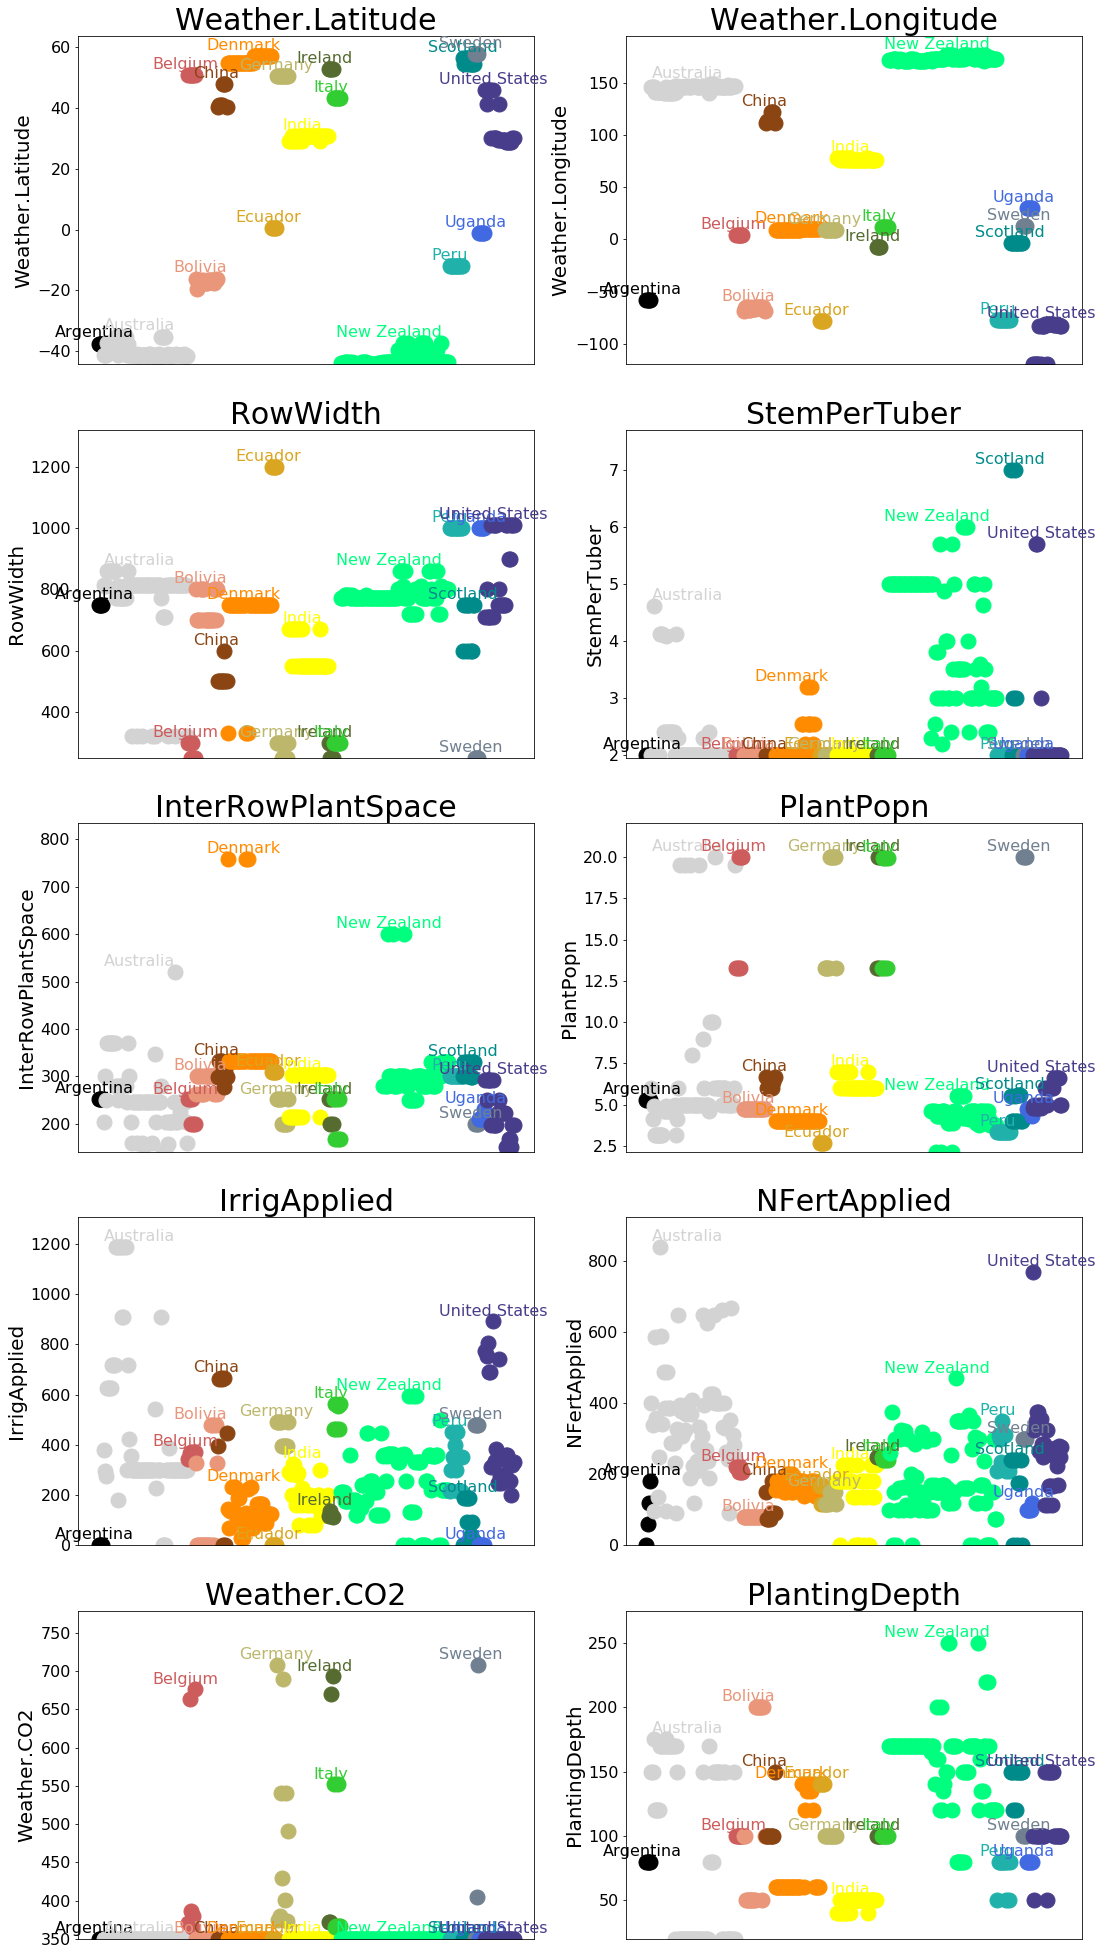

In [172]:
Graph = plt.figure(figsize=(18,35))
Vars = ['Weather.Latitude','Weather.Longitude',
       'RowWidth','StemPerTuber',
       'InterRowPlantSpace','PlantPopn',
       'IrrigApplied','NFertApplied',
       'Weather.CO2', 'PlantingDepth']
makeConfigPlots(Vars,'Country',Countries)

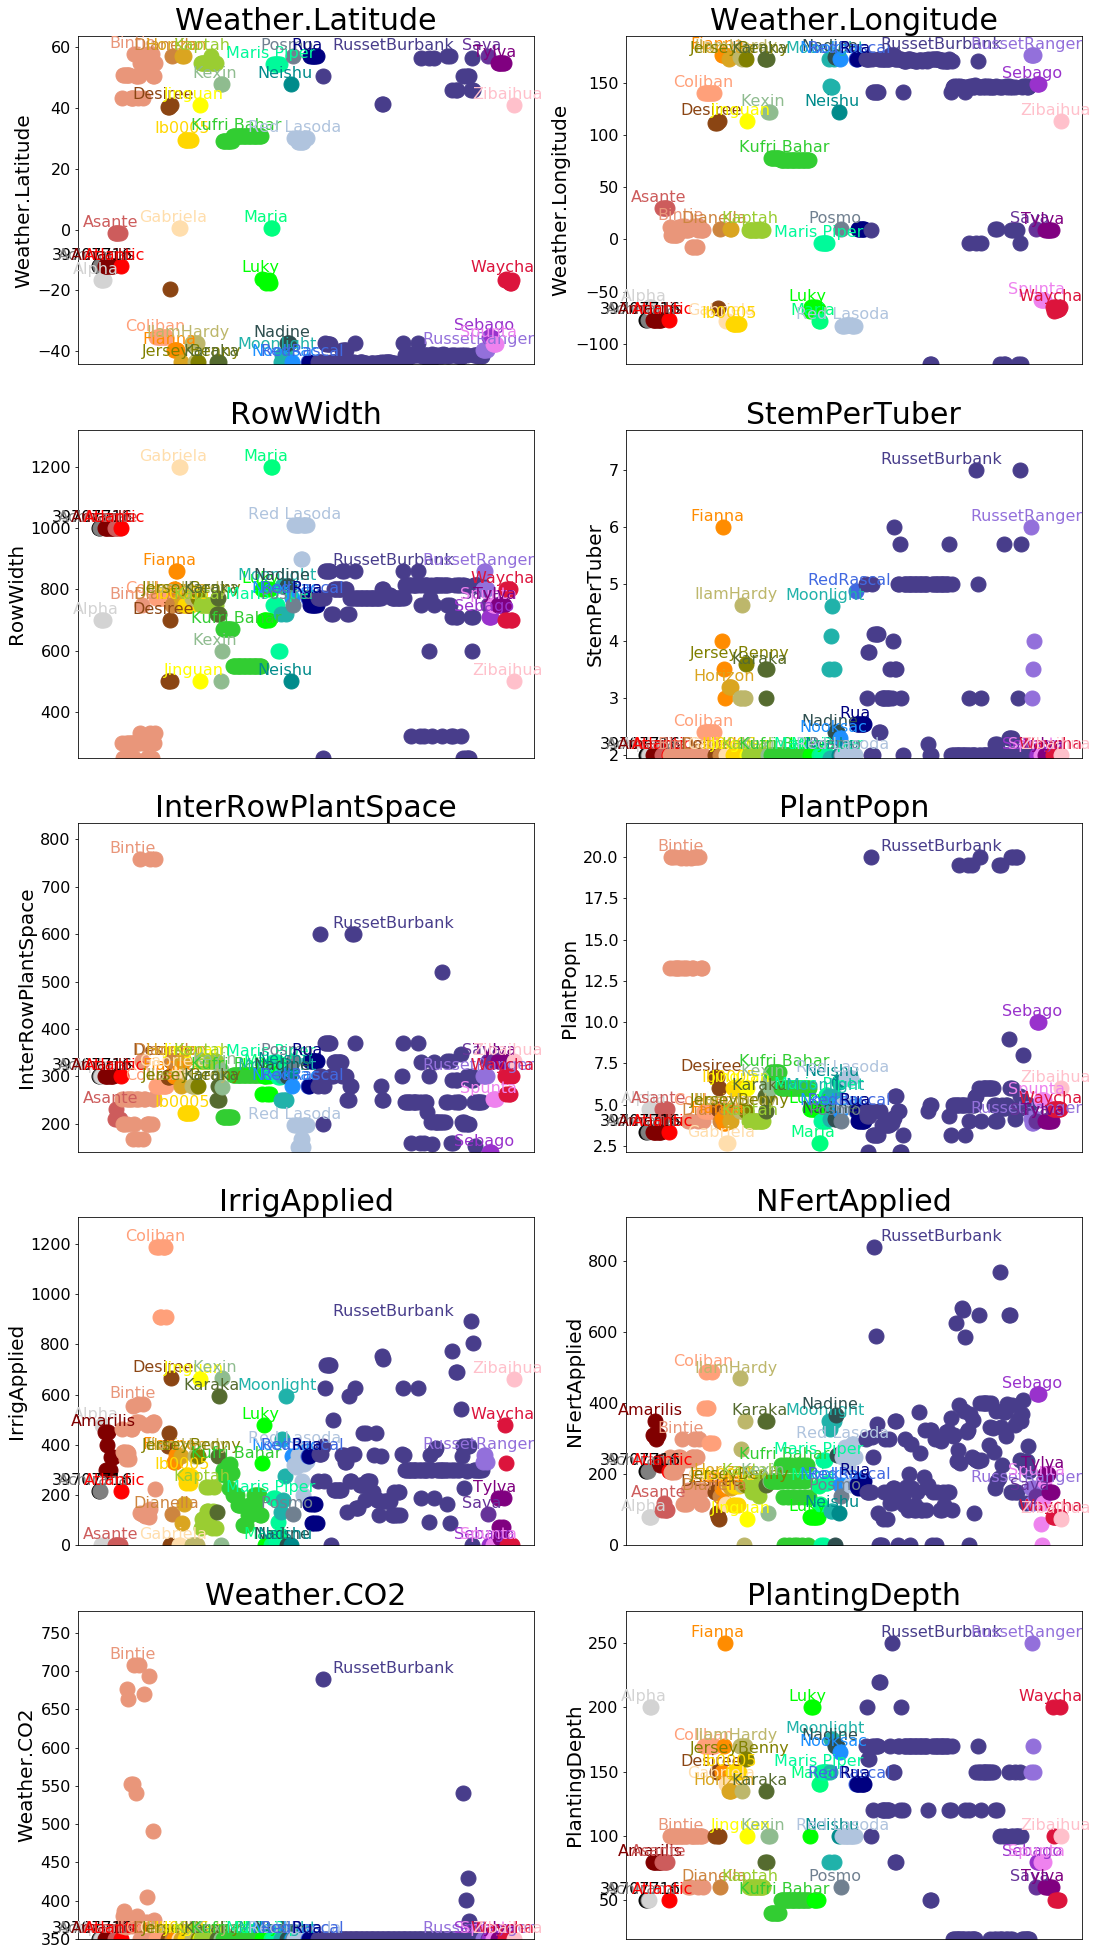

In [173]:
Graph = plt.figure(figsize=(18,35))
Vars = ['Weather.Latitude','Weather.Longitude',
       'RowWidth','StemPerTuber',
       'InterRowPlantSpace','PlantPopn',
       'IrrigApplied','NFertApplied',
       'Weather.CO2', 'PlantingDepth']
makeConfigPlots(Vars,'Cultivar',Cultivars)

In [33]:
def plotDepthVars(VarName,depthNorm):
    Thicks = InitialReport.loc[:,[X for X in InitialReport.columns if 'Thickness' in X]]
    Depths = Thicks.cumsum(axis=1)
    Vars = InitialReport.loc[:,[X for X in InitialReport.columns if VarName in X]]
    LayerDB = pd.DataFrame()
    for x in Depths.index:
        SimLayerDB = pd.DataFrame(index = pd.MultiIndex.from_product([[x],['LayerBounds','Varval']]))
        LayerBounds = [0.0]
        depthNormFact = 1 
        if depthNorm == True:
            depthNormFact = Thicks.loc[x,:][0]
        Varvals = [Vars.loc[x,:][0]/depthNormFact]
        for l in range(9):
            try:
                if depthNorm == True:
                    depthNormFact = Thicks.loc[x,:][l]
                LayerBounds.append(float(Depths.loc[x,:][l])*-1)
                Varvals.append(Vars.loc[x,:][l]/depthNormFact)
            except:
                do = 'Nothing'
        for p in range(len(LayerBounds)):
            SimLayerDB.loc[(x,'LayerBounds'),p] = LayerBounds[p]
            SimLayerDB.loc[(x,'Varval'),p] = Varvals[p]
        LayerDB = pd.concat([LayerDB,SimLayerDB])
        LayerDB.index = LayerDB.index.swaplevel()
        LayerBounds = LayerDB.stack().loc['LayerBounds']
        VarVals = LayerDB.stack().loc['Varval']
        LayerDB = pd.concat([LayerDB,SimLayerDB])
    MaxDep = LayerDB.loc[(slice(None),'LayerBounds'),:].min(axis=1).min()
    MinVar = LayerDB.loc[(slice(None),'Varval'),:].min(axis=1).min()
    MaxVar = LayerDB.loc[(slice(None),'Varval'),:].max(axis=1).max()    
    Graph = plt.figure(figsize=(10,20))
    cols = np.ceil(len(Locations)/5)
    pos=1
    for lcn in Locations:
        ax = Graph.add_subplot(cols,5,pos)
        #for x in Depths.index:
        #    plcn = InitialReport.loc[x,'Location']
        plt.plot(VarVals,LayerBounds,'o',color = 'lightgrey')
        plt.text(0.03,1.0,lcn,transform=ax.transAxes,fontsize=12)
        LocalVars = HarvestReport.loc[HarvestReport.loc[:,'Loc']==lcn,:].index
        for l in LocalVars:
            plt.plot(LayerDB.loc[(l,'Varval'),:],LayerDB.loc[(l,'LayerBounds'),:],'-o',color = 'red')
        plt.ylim(MaxDep*1.05,0)
        plt.xlim(MinVar * 0.8,MaxVar * 1.05)
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
        if pos in range(1,200,5):
            plt.tick_params(axis='y', which='both', left=True,right=False, labelleft=True,labelsize=10)
            plt.ylabel('Depth (cm)',fontsize=12)
        else:
            plt.tick_params(axis='y', which='both', left=False,right=False, labelleft=False,labelsize=10)
        if pos in list(range(len(Locations)-4,len(Locations)+1)):
            plt.tick_params(axis='x', which='both', bottom=True,top=False, labelbottom=True,labelsize=10)
            plt.xlabel(VarName,fontsize=12)
        else:
            plt.tick_params(axis='x', which='both', bottom=False,top=False, labelbottom=False,labelsize=10)
        pos += 1
    plt.tight_layout

## The flowing series of graphs show CropSoil configuration settings for each simulation so they can be sense checked against the rest of the validation set

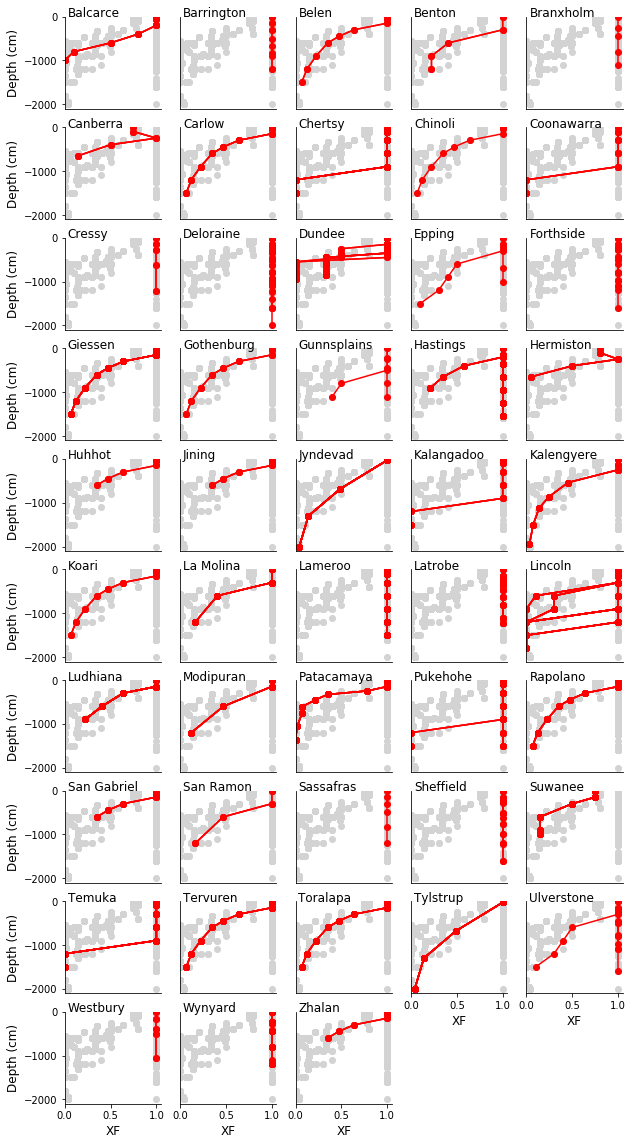

In [34]:
plotDepthVars('XF',False)

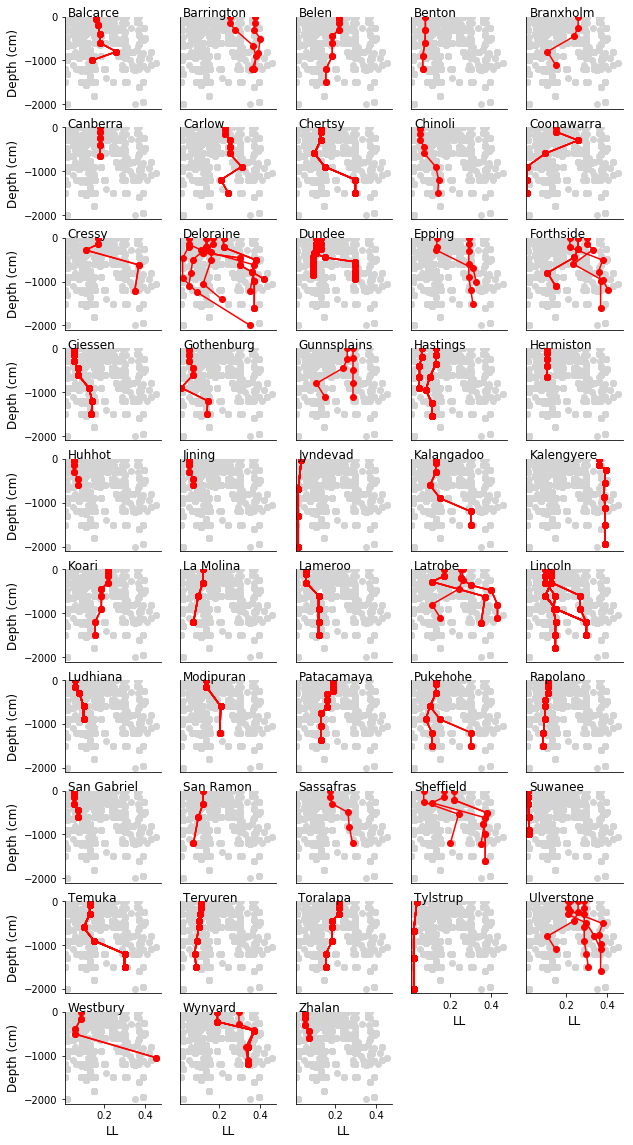

In [35]:
plotDepthVars('LL',False)

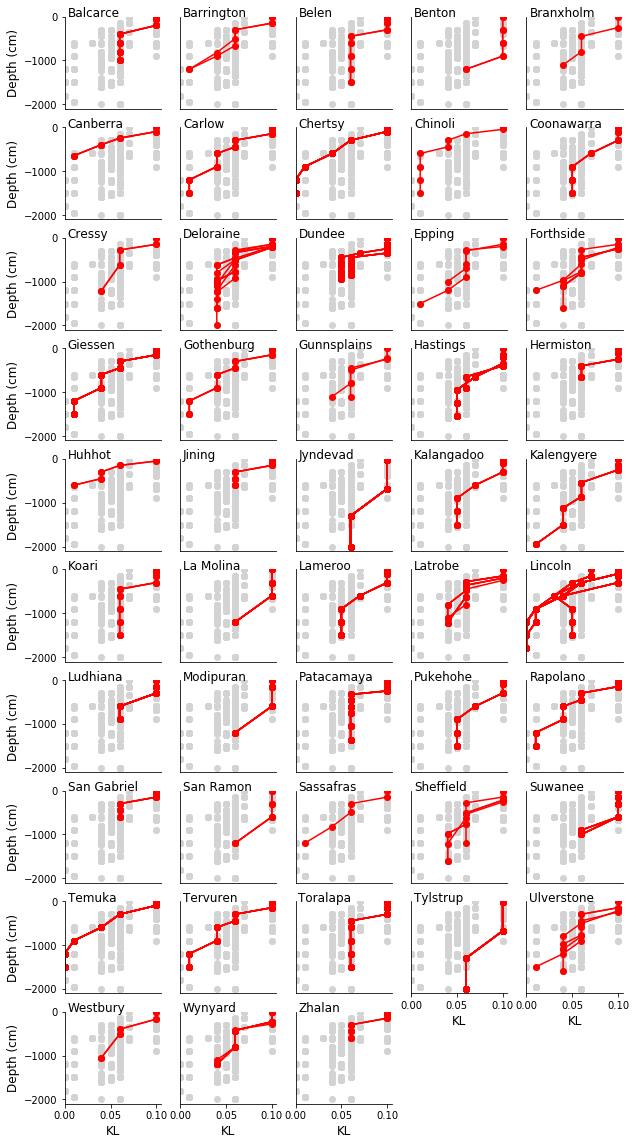

In [36]:
plotDepthVars('KL',False)

In [84]:
def MakeLabel(RegStats):
    #text = RegStats.Name + '  n = ' + str(RegStats.n)
    text = '\ny = ' + '%.2f'%RegStats.Intercept + '(se ' + '%.2f'%RegStats.SEintercept + ') + ' + '%.2f'%RegStats.Slope + '(se ' + '%.2f'%RegStats.SEslope + ') x' 
    text += '\n$r^2$ =' + '%.2f'%RegStats.R2 + ' RMSE = ' + '%.2f'%RegStats.RMSE +' NSE = ' + '%.2f'%RegStats.NSE
    text += '\nME = ' + '%.2f'%RegStats.ME + ' MAE = ' + '%.2f'%RegStats.MAE
    text += '\nn = ' + str(RegStats.n)
    return text

def AddObsPredGraph(Variables,DataTable,GroupVar,GroupList):
    Pos = 1
    for Var in Variables:
        NaNFilter = np.isnan(DataTable.loc[:,'Predicted.'+Var]) | np.isnan(DataTable.loc[:,'Observed.'+Var])
        IaNFilter = ~NaNFilter
        Obs = DataTable.loc[:,'Observed.'+Var].loc[IaNFilter].values
        Pred = DataTable.loc[:,'Predicted.'+Var].loc[IaNFilter].values
        no = len(Variables)
        rows = np.ceil(no/3)
        ax = Graph.add_subplot(rows,3,Pos)
        ColPos = 0
        MarPos = 0
        for g in GroupList:
            ColDF = globals()[GroupVar+'Props']
            col = ColDF.loc[g,'Color']
            SimIDs = HarvestReport.loc[HarvestReport.loc[:,GroupVar] == g].index.values
            ExpObs = DataTable.loc[SimIDs,'Observed.'+Var]
            ExpPred = DataTable.loc[SimIDs,'Predicted.'+Var]
            plt.plot(ExpObs,ExpPred,Markers[MarPos],color = col,label=g)
            ColPos +=1
            if ColPos == 30:
                ColPos = 1
                MarPos +=1
        uplim = max(Obs.max(),Pred.max())*1.1
        lowlim = min(Obs.min(),Pred.min())*0.95
        plt.text(0.02,0.94,Var,transform=ax.transAxes)
        plt.ylim(0,uplim)
        plt.xlim(0,uplim)
        plt.plot([lowlim,uplim*.95],[lowlim,uplim*.95],'-')
        RegStats = MUte.MathUtilities.CalcRegressionStats(Var,Pred,Obs)
        LabelText = MakeLabel(RegStats)
        #plt.text(uplim*0.05,uplim*.78,LabelText)
        #Fit linear regression to current series and store slope and intercept in dataframe
        ModFit = sm.regression.linear_model.OLS(Pred,  # Y variable
                                            sm.add_constant(Obs), # X variable
                                            missing='drop',                                     # ignor and data where one value is missing
                                            hasconst=False) 
        RegFit = ModFit.fit();  # fit models parameters
        Slope = RegFit.params[1] 
        Intercept = RegFit.params[0]
        Xs = [lowlim,uplim*.95]
        Ys = [Intercept + Xs[0]*Slope,Intercept + Xs[1]*Slope]
        plt.plot(Xs,Ys,'--')
        Pos +=1

## Standard Obs vs Pred graph for Harvest

C:\Anaconda\lib\site-packages\pandas\core\indexing.py:1027: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return getattr(section, self.name)[new_key]


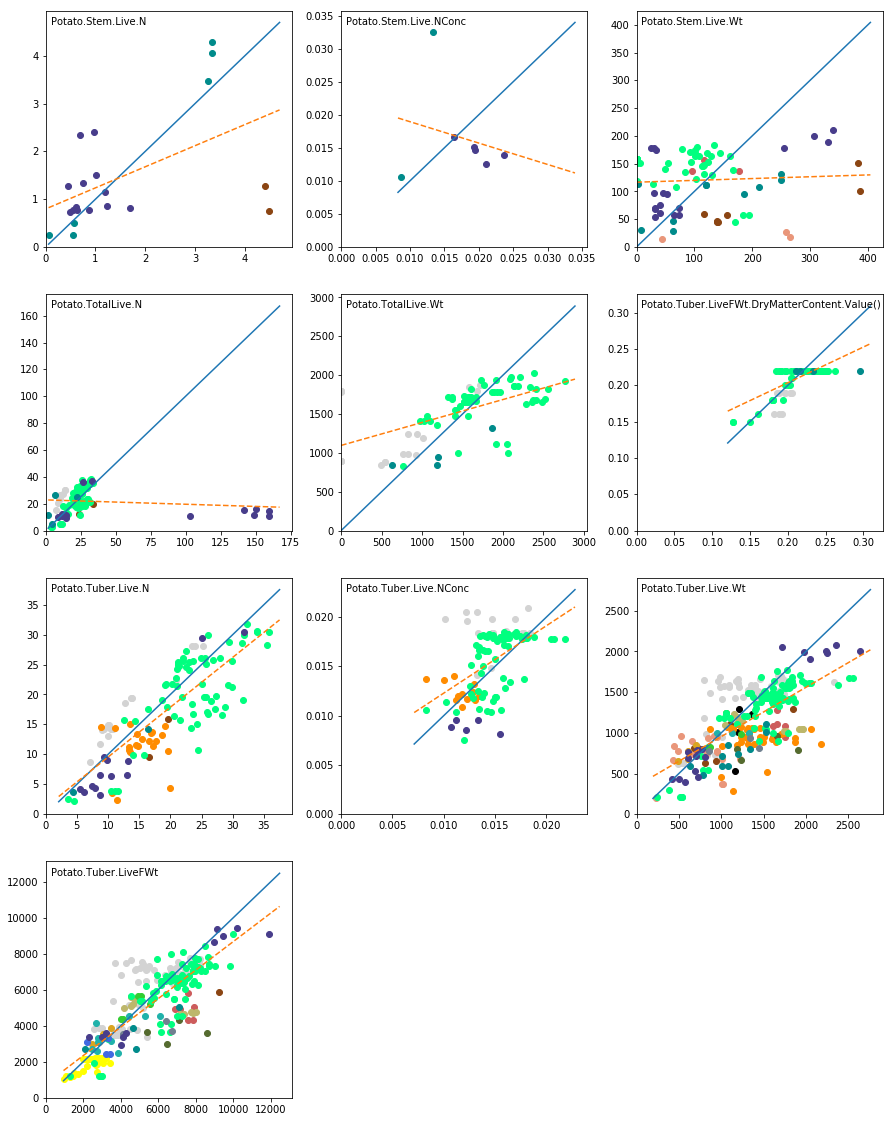

In [174]:
Graph = plt.figure(figsize=(15,20))
AddObsPredGraph(PlotVariables,HarvestPreObs,'Country',Countries)

## Standard Obs vs Pre graph for time series data

C:\Anaconda\lib\site-packages\pandas\core\indexing.py:1027: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return getattr(section, self.name)[new_key]


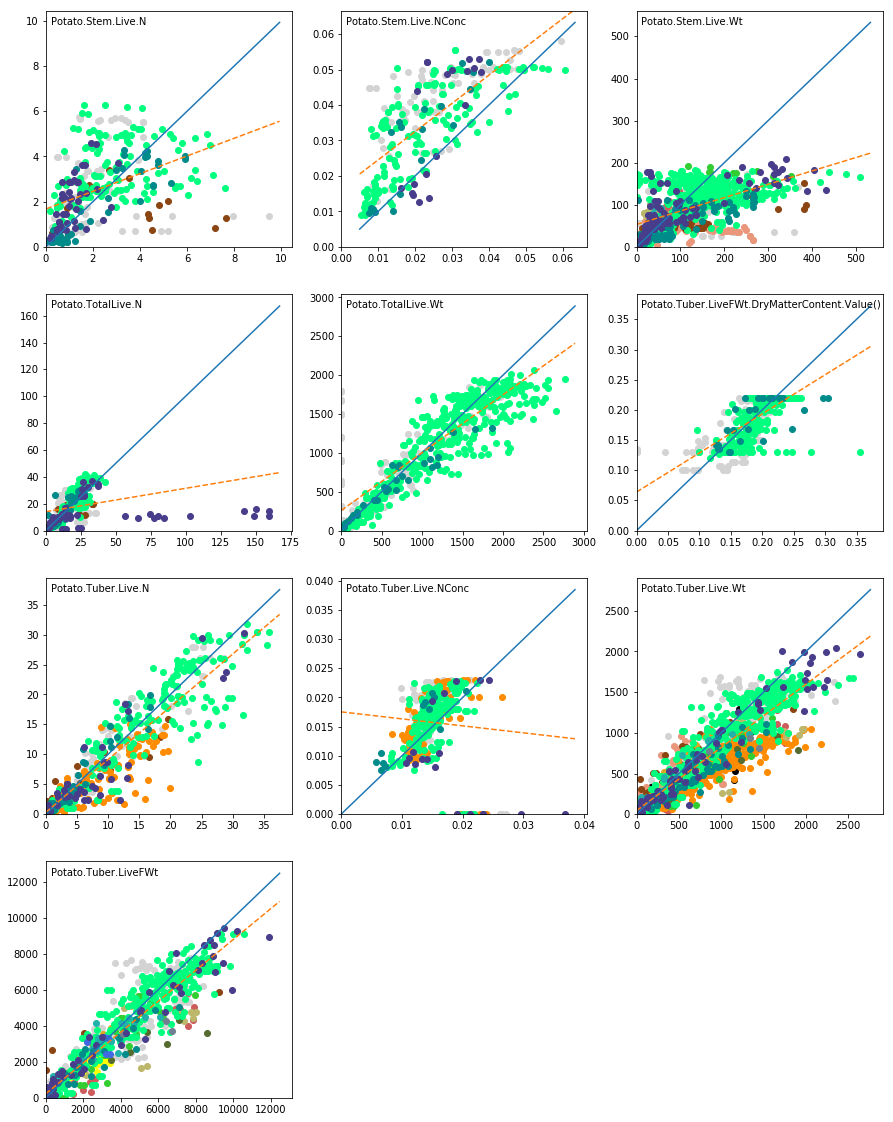

In [175]:
Graph = plt.figure(figsize=(15,20))
AddObsPredGraph(PlotVariables,DailyPreObs,'Country',Countries)

In [42]:
HarvestResiduals = HarvestPreObs.loc[:,[X for X in HarvestPreObs.columns if 'Pred-Obs' in X]].copy()

In [105]:
def GroupResidulesGraph(Variables,ResidulesTable,GroupList,GroupVar):
    panpos = 1
    rows = len(Variables)
    for Var in Variables:
        ax = Graph.add_subplot(rows,1,panpos)
        startx = 0
        tickPoss = []
        tickLabs = []
        colpos = 1
        upper = ResidulesTable.loc[:,'Pred-Obs.' + Var].max() * 1.1
        lower = ResidulesTable.loc[:,'Pred-Obs.' + Var].min() * 1.1
        MeanResidual = ResidulesTable.loc[:,'Pred-Obs.' + Var].mean()
        TextPos = 'Lower'
        for group in GroupList:
            ColDF = globals()[GroupVar+'Props']
            col = ColDF.loc[group,'Color']
            SimIDs = HarvestReport.loc[HarvestReport.loc[:,GroupVar]==group,:].index.values
            xvals = range(startx,startx+len(SimIDs))
            plt.plot(xvals,ResidulesTable.reindex(SimIDs,axis=0).loc[:,'Pred-Obs.' + Var],
                     '-o',color=col)
            #tickPoss.append(startx+len(SimIDs)/2)
            tickLabs.append(group)
            if TextPos=='Lower':
                plt.text(startx+len(SimIDs)/2,lower,group,fontsize=16,
                         color=col,rotation=-45,verticalalignment='bottom',horizontalalignment='center')
                TextPos = 'Upper'
            else:
                plt.text(startx+len(SimIDs)/2,upper,group,fontsize=16,
                         color=col,rotation=-45,verticalalignment='top',horizontalalignment='center')
                TextPos = 'Lower'
            startx += len(SimIDs)
            if colpos == 30:
                colpos = 0
            colpos+=1
        ax.xaxis.set_major_locator(plt.FixedLocator(tickPoss))
        ax.set_xticklabels(tickLabs)
        plt.tick_params(rotation=90)
        plt.plot([0,startx],[MeanResidual,MeanResidual],'-',lw=3,color='k')
        plt.plot([0,startx],[0,0],'--',lw=3,color='k')
        plt.ylim(lower,upper)
        plt.title(Var,fontsize=25)
        plt.ylabel('Pred-Obs')
        panpos+=1

## Graph residuals for key variables grouped by cultivar

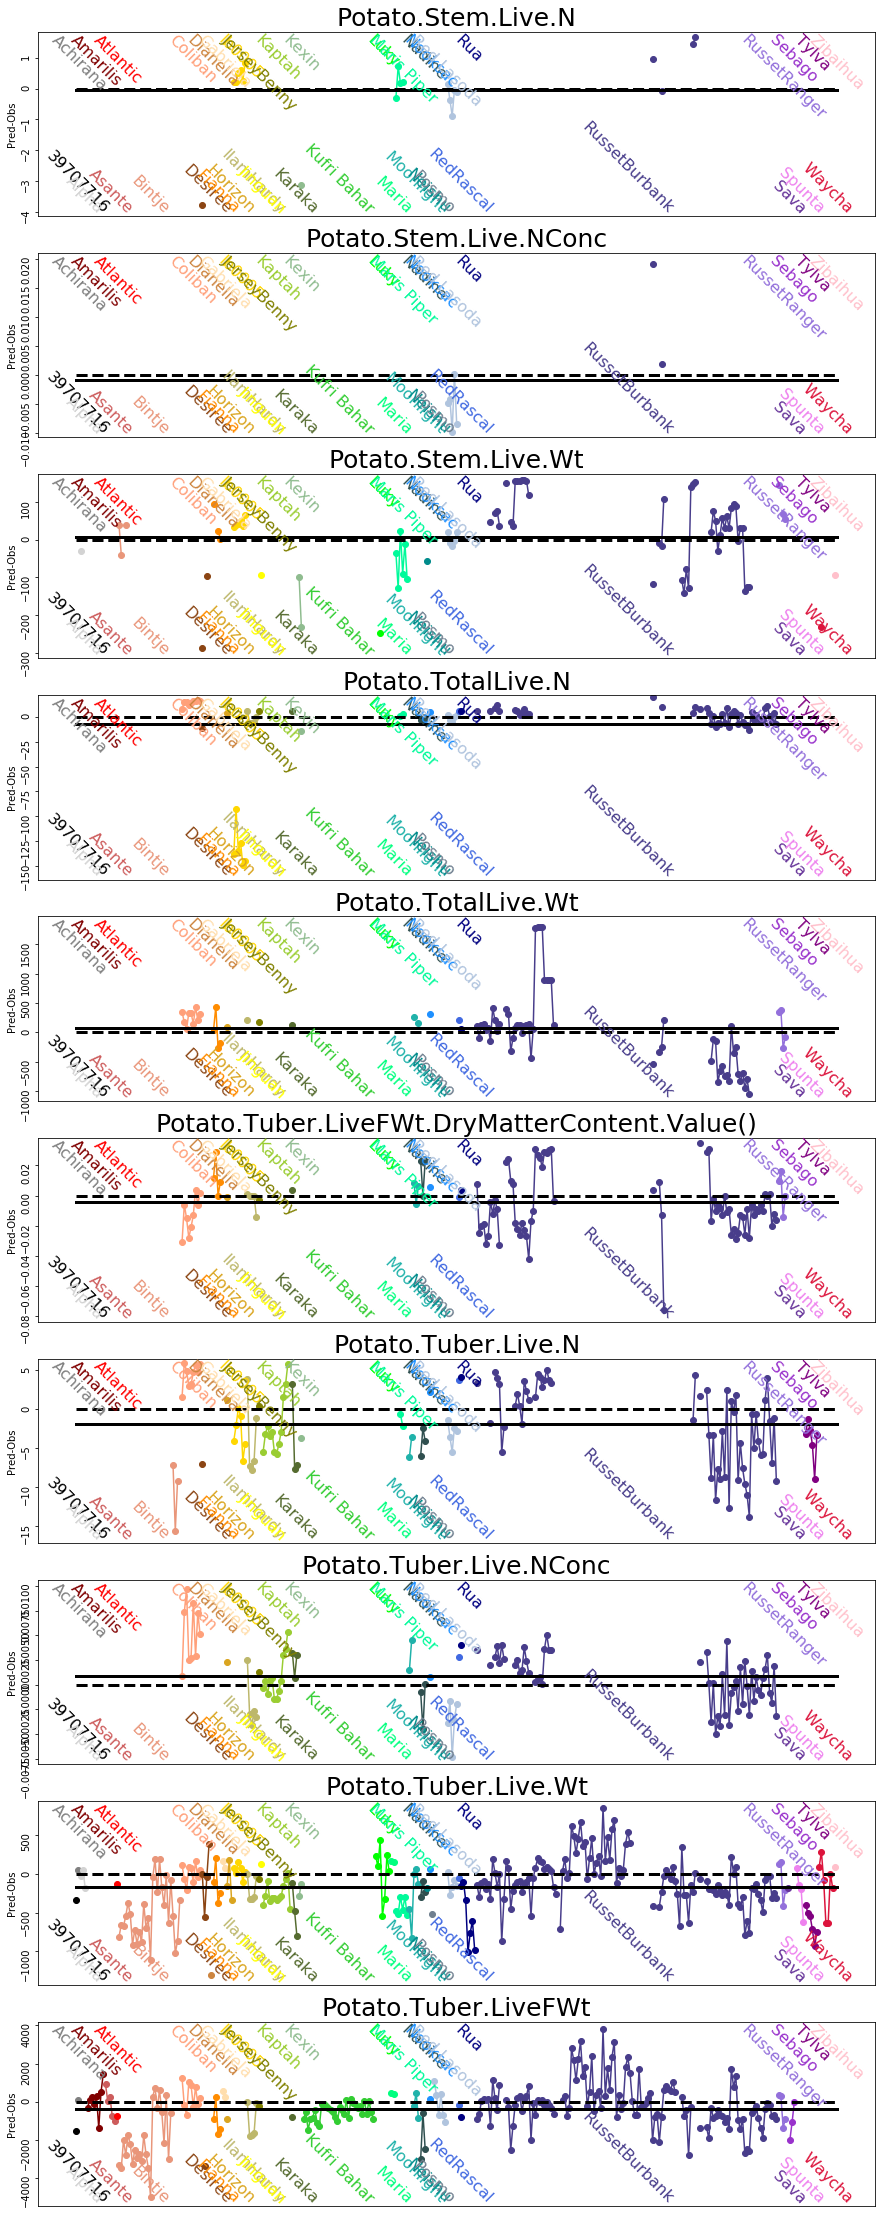

In [176]:
Graph = plt.figure(figsize=(15,40))
GroupResidulesGraph(PlotVariables,HarvestResiduals,Cultivars,'Cultivar')

## Graph residuals for key variables grouped by location

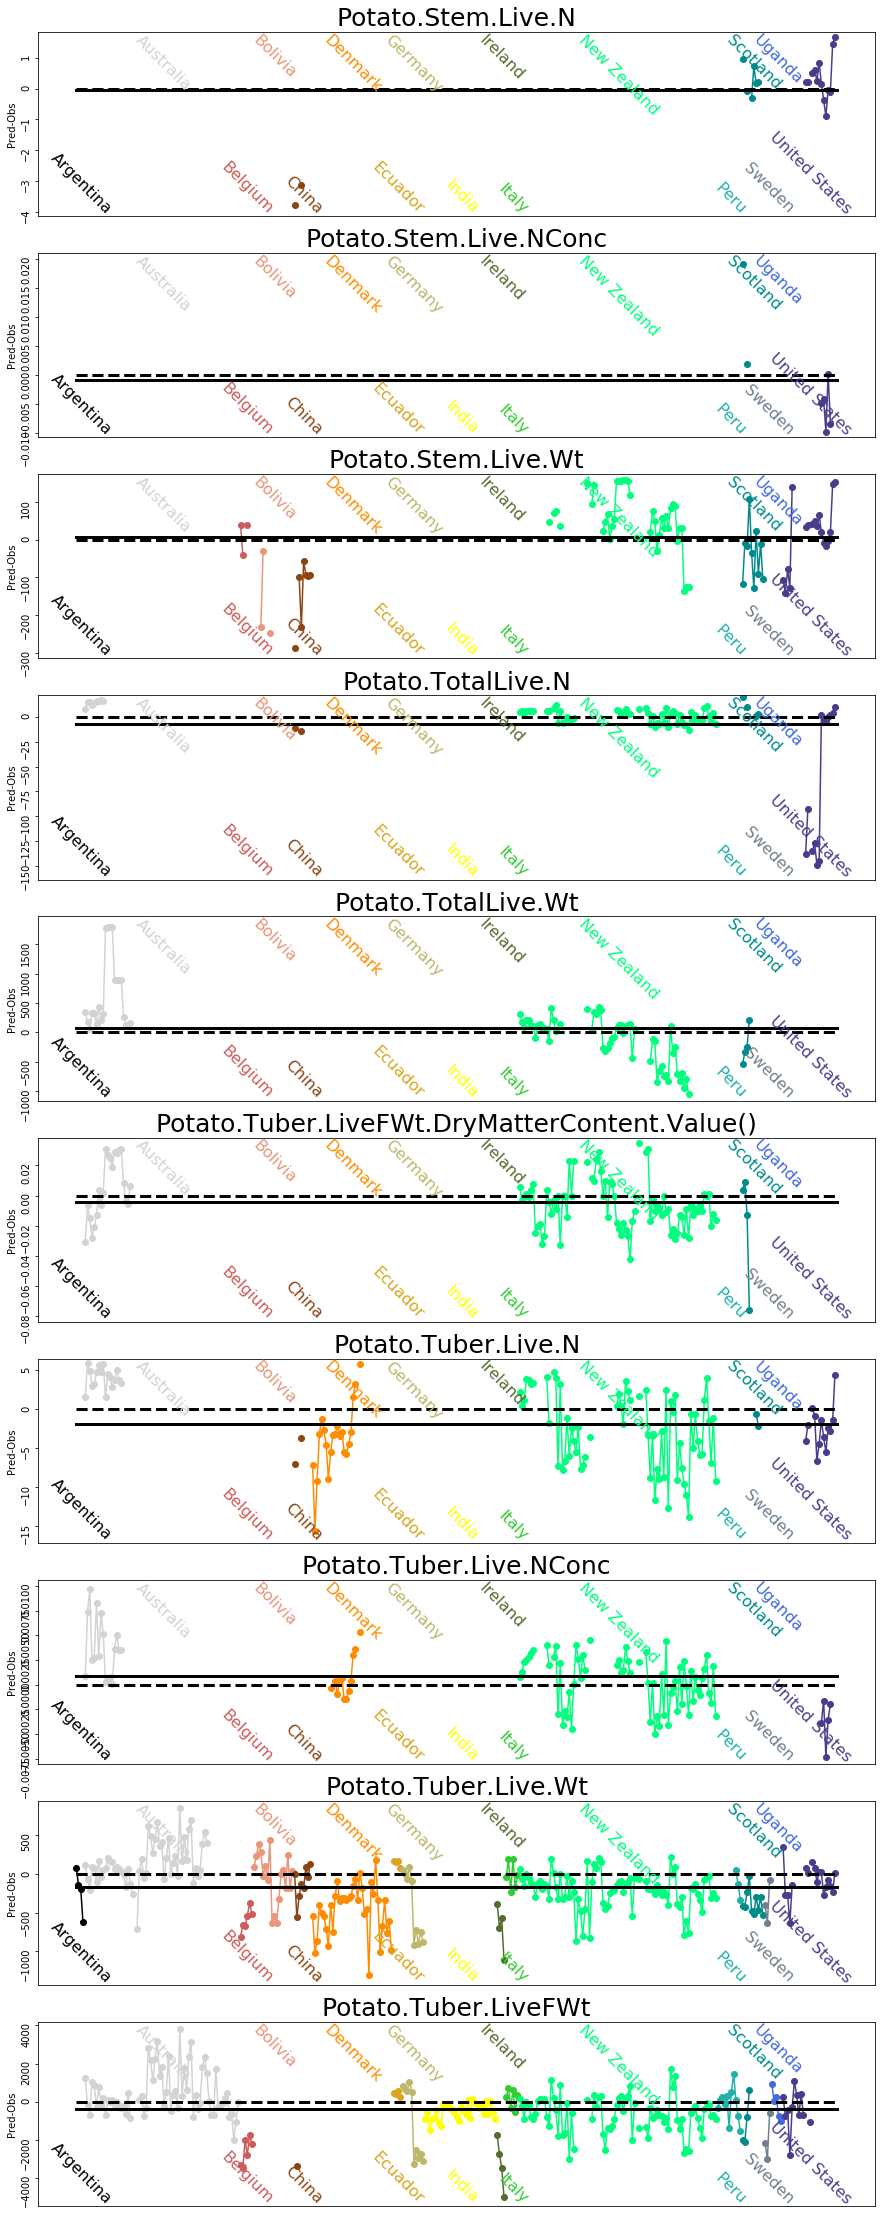

In [177]:
Graph = plt.figure(figsize=(15,40))
GroupResidulesGraph(PlotVariables,HarvestResiduals,Countries,'Country')

## Make graphs of residuals vs simulation configuration variables

In [110]:
def ResidulesVsVariable(ResidulesTable,Variable,GroupList,GroupVar):
    pos = 1
    for vsVariable in ['IrrigApplied','NFertApplied','Weather.Latitude',
                       'Weather.Longitude','PlantPopn','StemPopn']:
        Graph.add_subplot(3,2,pos)
        for group in GroupList:
            ColDF = globals()[GroupVar+'Props']
            col = ColDF.loc[group,'Color']
            SimIDs = HarvestReport.loc[HarvestReport.loc[:,GroupVar]==group,:].index.values
            yvals = ResidulesTable.reindex(SimIDs,axis=0).loc[:,'Pred-Obs.Potato.'+Variable]
            xvals = HarvestReport.reindex(SimIDs,axis=0).loc[:,vsVariable]
            plt.plot(xvals,yvals,'o',color=col)
            upper = HarvestReport.loc[:,vsVariable].max() * 1.1
            lower = HarvestReport.loc[:,vsVariable].min() * 0.8
            MeanResidual = ResidulesTable.loc[:,'Pred-Obs.Potato.' + Variable].mean()
            plt.plot([lower,upper],[MeanResidual,MeanResidual],'-',lw=3,color='k')
            plt.plot([lower,upper],[0,0],'--',lw=3,color='k')
            plt.title('Pred-Obs ' + Variable + ' vs ' + vsVariable)
            plt.ylabel('Pred-Obs ' + Variable)
            plt.xlabel(vsVariable)
        pos+=1

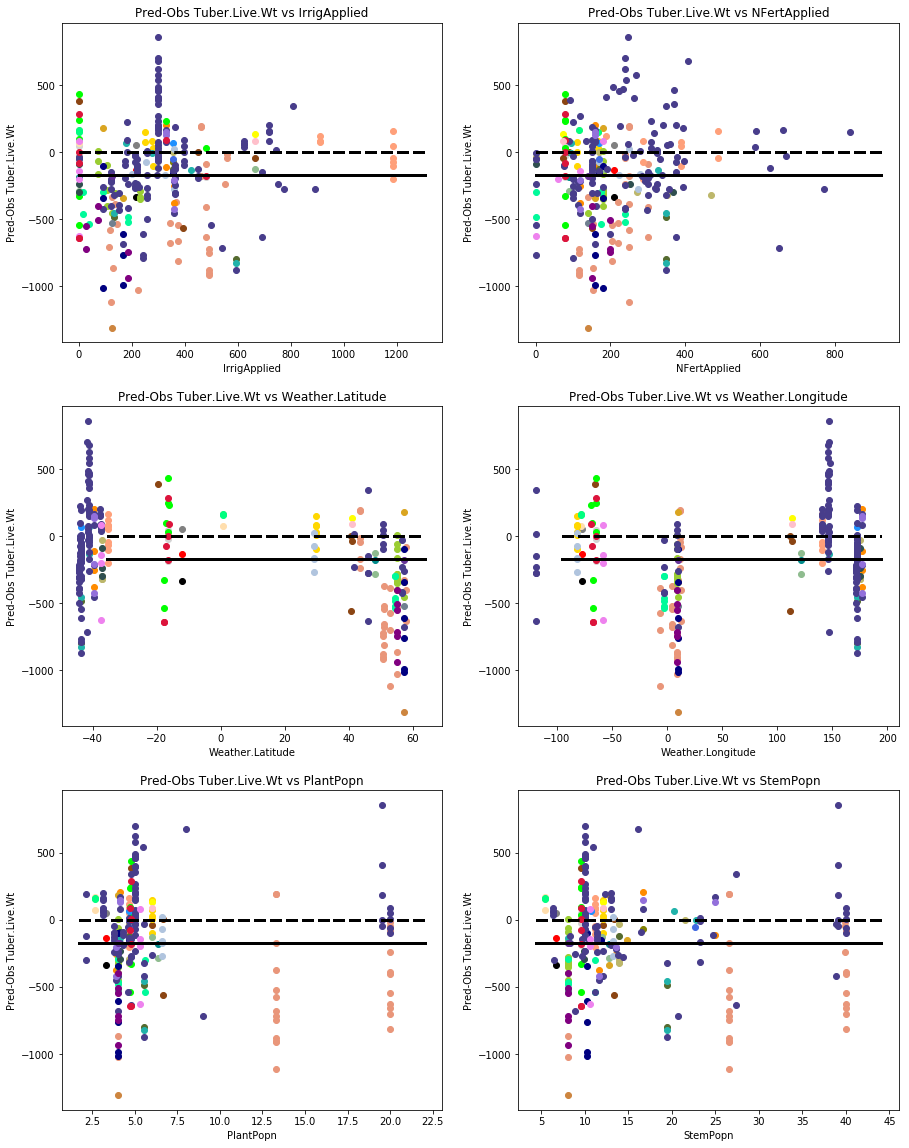

In [178]:
Graph = plt.figure(figsize=(15,20))
ResidulesVsVariable(HarvestResiduals,'Tuber.Live.Wt',Cultivars,'Cultivar')

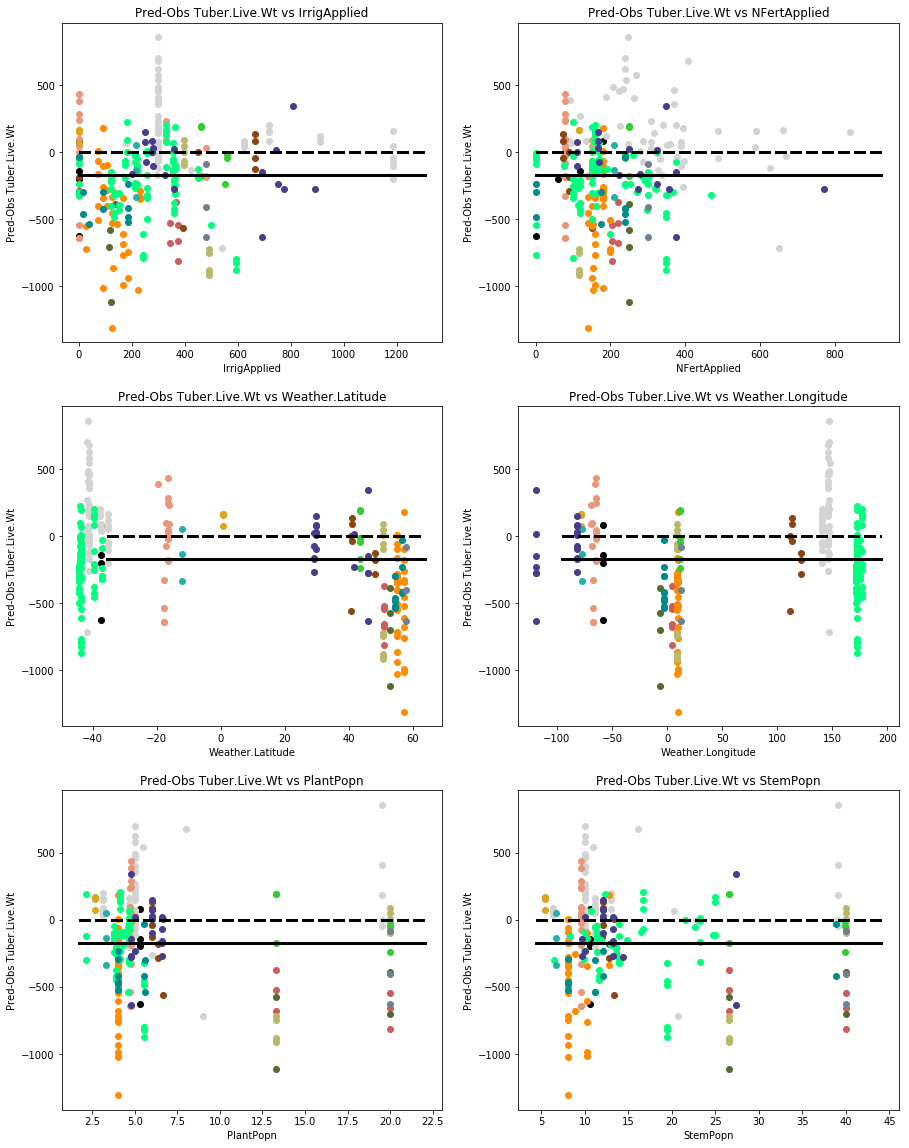

In [179]:
Graph = plt.figure(figsize=(15,20))
ResidulesVsVariable(HarvestResiduals,'Tuber.Live.Wt',Countries,'Country')

In [76]:
def simsWithTimeCoarseData(Var):
    SimsWithTimeCoarseData = []
    for sim in DailyPreObs.index.drop_duplicates():
        try:
            obsNo = len(DailyPreObs.loc[sim,'Pred-Obs.Potato.'+Var].dropna().values)
            if obsNo>1:
                SimsWithTimeCoarseData.append(sim)
        except:
            do = 'Nothing'
    return SimsWithTimeCoarseData

def ResidulesVsTtSow(Variable,GroupLabel,colourLabel):
    SimsWithTimeDataForVar = simsWithTimeCoarseData(Variable)
    WithTimeCoarseData = HarvestReport.reindex(SimsWithTimeDataForVar,axis=0).loc[:,GroupLabel].dropna().drop_duplicates().values
    Grouping = WithTimeCoarseData
    Grouping.sort()
    cols = np.ceil(len(Grouping)/5)
    pos=1
    upper = DailyPreObs.loc[:,'Pred-Obs.Potato.'+Variable].max() * 1.1
    lower = DailyPreObs.loc[:,'Pred-Obs.Potato.'+Variable].min() * 0.8
    MeanResidual = DailyPreObs.loc[:,'Pred-Obs.Potato.'+Variable].mean()
    DailyObsPredSims = DailyPreObs.index.drop_duplicates()
    for group in Grouping:
        ax = Graph.add_subplot(cols,5,pos)
        simsInGroup = HarvestReport.loc[HarvestReport.loc[:,GroupLabel]==group].index
        GroupSimsWithTimeCoarseData = list(set(HarvestReport.loc[HarvestReport.loc[:,GroupLabel]==group].index) & set(SimsWithTimeDataForVar))
        for sim in GroupSimsWithTimeCoarseData:
            col = ColProps.loc[sim,colourLabel]
            residuals = DailyPreObs.loc[sim,'Pred-Obs.Potato.'+Variable]
            DatesWithObs = DailyReport.loc[:,'Clock.Today'].isin(DailyPreObs.loc[sim,'Clock.Today'])
            TtSow = DailyReport.loc[DatesWithObs,:].loc[sim,'Potato.Phenology.AccumulatedEmergedTT'].values
            try:
                plt.plot(TtSow,residuals,'o-',color=col)
            except:
                print(sim)
        plt.text(0.03,1.0,group,transform=ax.transAxes,fontsize=12)
        plt.ylim(lower,upper)
        plt.plot([0,2300],[MeanResidual,MeanResidual],'-',lw=3,color='k')
        plt.plot([0,2300],[0,0],'--',lw=3,color='k')
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
        if pos in range(1,200,5):
            plt.tick_params(axis='y', which='both', left=True,right=False, labelleft=True,labelsize=10)
            plt.ylabel('Pred-Obs '+Variable,fontsize=12)
        else:
            plt.tick_params(axis='y', which='both', left=False,right=False, labelleft=False,labelsize=10)
        if pos in list(range(len(Grouping)-4,len(Grouping)+1)):
            plt.tick_params(axis='x', which='both', bottom=True,top=False, labelbottom=True,labelsize=10)
            plt.xlabel('TtAccumSow',fontsize=12)
        else:
            plt.tick_params(axis='x', which='both', bottom=False,top=False, labelbottom=False,labelsize=10)
        pos+=1
    plt.tight_layout

## Make Graphs of tuber live Wt residuals for each location plotted against thermal time since sowing

44
45
46
47
48
49
50
120


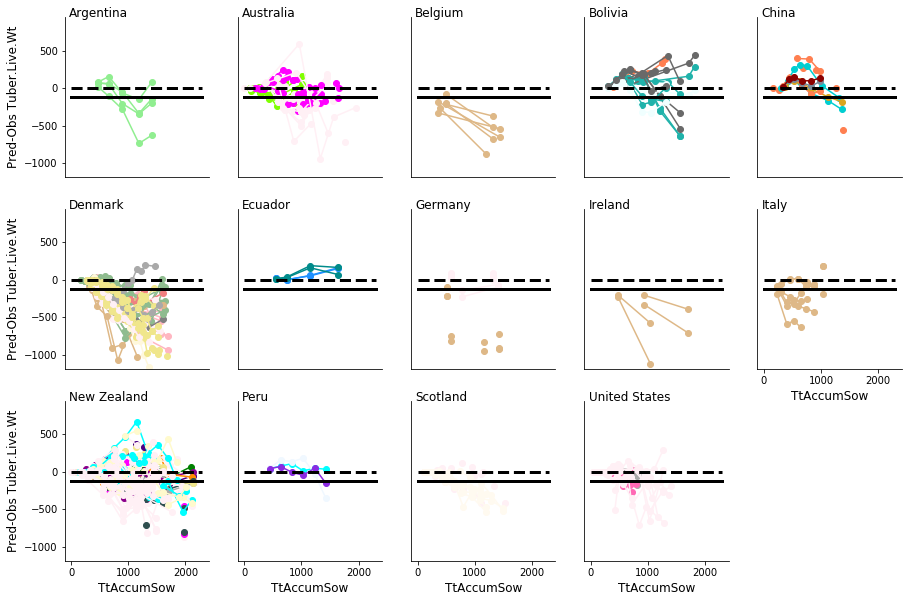

In [77]:
Graph = plt.figure(figsize=(15,10))
PlotVar = 'Tuber.Live.Wt'
SortVar = 'Country'
ColorVar = 'Cultivar'
ResidulesVsTtSow(PlotVar,SortVar,ColorVar)

## Make Graphs of tuber live Wt residuals for each Cultivar plotted against thermal time since sowing

44
45
46
47
48
49
50
120


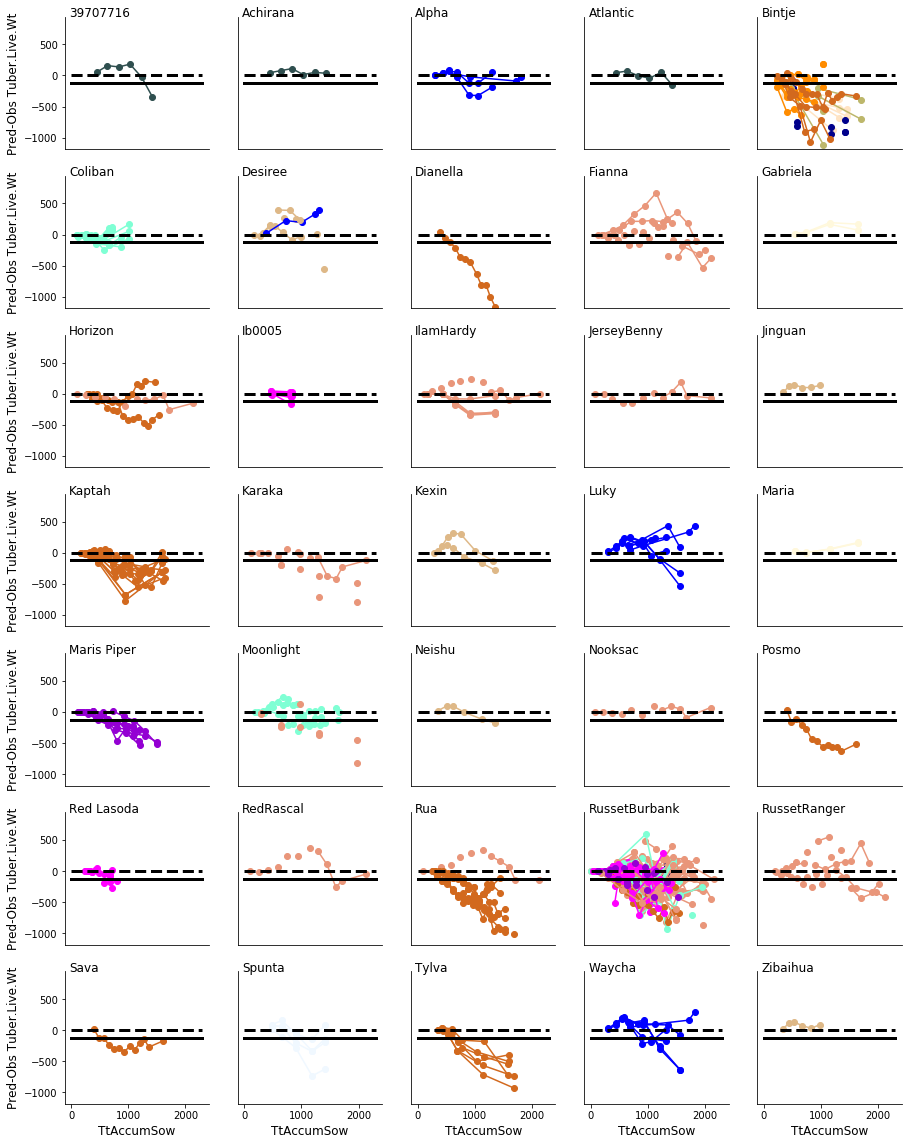

In [78]:
Graph = plt.figure(figsize=(15,20))
PlotVar = 'Tuber.Live.Wt'
SortVar = 'Cultivar'
ColorVar = 'Country'
ResidulesVsTtSow(PlotVar,SortVar,ColorVar)

## Make Graphs of LAI residuals for each cultivar plotted against thermal time since sowing

44
45
46
47
48
49
50
120


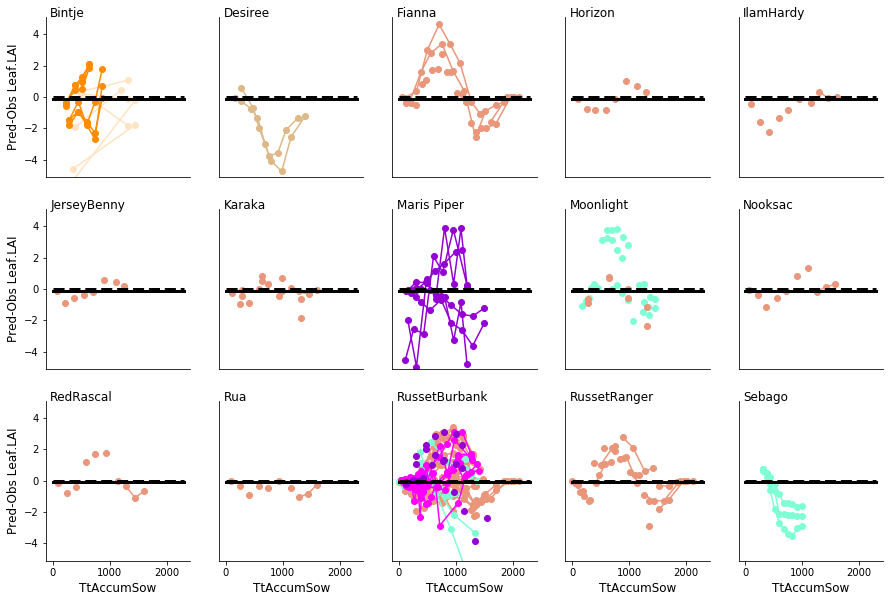

In [79]:
Graph = plt.figure(figsize=(15,10))
PlotVar = 'Leaf.LAI'
SortVar = 'Cultivar'
ColorVar = 'Country'
ResidulesVsTtSow(PlotVar,SortVar,ColorVar)

44
45
46
47
48
49
50
120


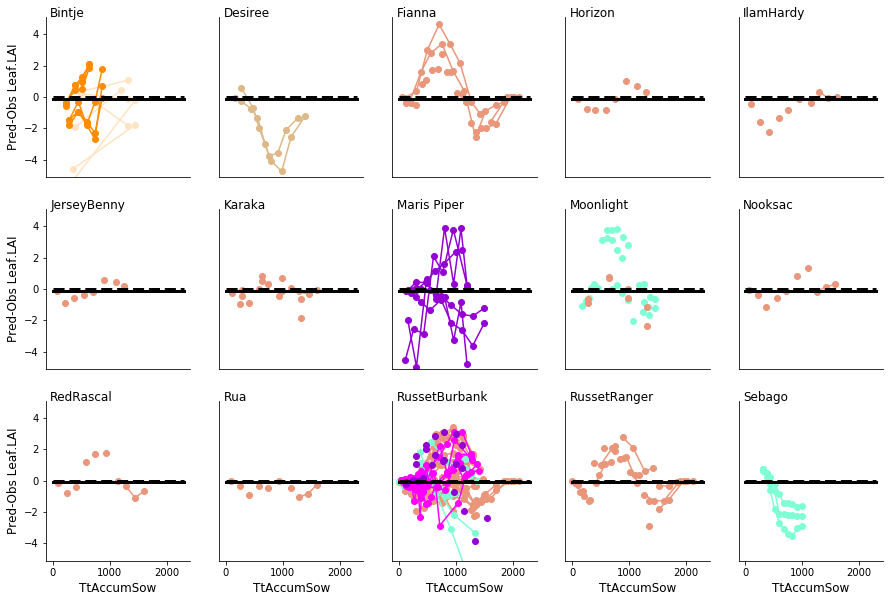

In [80]:
Graph = plt.figure(figsize=(15,10))
ResidulesVsTtSow('Leaf.LAI','Cultivar','Country')